# Finetuning de un Decoder-only LLM con LoRA en contexto biomédico

El propósito de este notebook es aplicar Domain Adaptation Pre-Training o entrenamiento continuado usando LoRA para finetunear un modelo de lenguaje grande (LLM) de tipo decoder-only en un dominio específico, en este caso, el contexto biomédico. Utilizaremos la biblioteca `transformers` de Hugging Face junto con `peft` para implementar LoRA.

In [8]:
!pip install trl evaluate --quiet

En primer lugar, se carga un dataset con los documentos para el preentrenamiento continuado.

In [55]:
import pandas as pd
import torch
import math
import numpy as np
from datasets import Dataset

from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    DataCollatorForLanguageModeling,
)

from peft import (
    LoraConfig,
    PeftModel,
    prepare_model_for_kbit_training,
    get_peft_model
)

import evaluate
from tqdm import tqdm

# métricas de clasificación
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix,
)

# visualización
import matplotlib.pyplot as plt
import seaborn as sns

from trl import SFTTrainer

Se carga el dataset con documentos médicos, limitandolo a 500 mil documentos y se pasa a un dataset de huggingface.

In [27]:
# leer los datos
cowese_data = pd.read_csv("data/documentos_cowese.csv", nrows = 5000)
print("Loaded data")

# asegurarse de que no hay none
cowese_data["document"] = cowese_data["document"].fillna("")

# convertir a dataset de hf
hf_dataset = Dataset.from_pandas(cowese_data[["document"]])
hf_dataset = hf_dataset.rename_column("document", "text")

Loaded data


In [32]:
cowese_data.iloc[200].document

'Aunque la conducta que debe seguirse ante los traumatismos graves de la columna cervical está bien establecida, no sucede lo mismo con la conducta relativa al tratamiento de la columna cervical postraumática benigna no neurológica, en la que una atención médica inadecuada o tardía puede favorecer el paso a la cronicidad, a menudo mantenida por el contexto psicológico y medicolegal. El síndrome subjetivo de los pacientes afectados por un traumatismo de la columna cervical no debería producirse si se instaurara una reeducación eficaz y precoz basada en las finalidades funcionales de este segmento raquídeo. Palabras Clave: Látigo cervical, Latigazo, Traumatismo de la nuca, Lesión craneocervical por aceleración, Cervicalgias postraumáticas, Masokinesiterapia, Reeducación muscular, Kinesiterapia educativa'

A continuación se carga el tokenizer con el correspondiente padding a la derecha. El modelo que se va a adaptar es Mistral Instruct con 7 billones de parámetros.

In [12]:
model_name = "mistralai/Mistral-7B-Instruct-v0.3"

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.padding_side = "right"
tokenizer.pad_token = tokenizer.eos_token

A continuación se configura y carga el modelo usando cuantización en 4bits, para reducir la memoria y permitir el fine-tuning. En primer lugar, BitsAndBytesConfig define cómo se cuantiza el modelo e indica que todos los pesos se cargaran en 4bits (en nf4, un poco más preciso). El parámetro bfloat16 define el tipo numérico usado durante el cálculo.
Luego se carga el modelo ya cuantizado con dica configuración, y se termina de ajustar para que se pueda entrenar bajo dicha cuantización sin perder estabilidad.

In [13]:
# configuraciones de la cuantización
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
)


# cargar el modelo en 4bit
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    quantization_config=bnb_config
)

# preparar el modelo para entrenamiento en 4bit
model = prepare_model_for_kbit_training(model)

Loading checkpoint shards: 100%|██████████████████| 3/3 [00:13<00:00,  4.55s/it]


Ahora se configura e insertan las matrices de LoRA en el modelo para hacer su finetuning. Las configuraciones más relevantes son las siguientes:
- rango de las matrices A y B es 16.
- se añade dropout para evitar sobreajuste.
- se especifica que la tarea para la cual se está adaptando es CAUSAL_LM, pues queremos generar texto con contexto médico.
- se aplica LoRA sobre los vectores q,v y k de los transformers.

In [14]:
# configuración de LoRA
peft_config = LoraConfig(
    r=16,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=[
        "q_proj", "k_proj", "v_proj"
    ]
)

# se inyecta LoRA en el modelo
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 9,437,184 || all params: 7,257,460,736 || trainable%: 0.1300


Ahora se prepara todo para entrenar el modelo con *Supervised Fine-Tuning* usando un dataset de texto continuo. Primero, se crea un data collator que toma los ejemplos del dataset y los arma en batches listos para el modelo, sin usar enmascaramiento porque en CAUSAL_LM el objetivo es predecir el siguiente token. Luego, se configuran los TrainingArguments, con las siguientes características principales:

- el directorio donde se guardarán los checkpoints.
- un batch efectivo pequeño usando *gradient accumulation* para ahorrar memoria.
- el warmup y la tasa de aprendizaje para estabilizar el entrenamiento.
- el uso de `bf16` para minimizar consumo de memoria.
- la frecuencia de logging y guardado.
- y un optimizador paginado compatible con cuantización.

Finalmente, se crea el **SFTTrainer**, que combina el modelo, el dataset, el collator y la configuración de entrenamiento, encargándose automáticamente del loop de finetuning y del guardado adecuado de los pesos LoRA.


In [33]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)


# argumentos de training
training_args = TrainingArguments(
    output_dir="./mistral_cowese_dapt",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    warmup_steps=5,
    learning_rate=2e-4,
    fp16=False,
    bf16=True,
    num_train_epochs=1,
    logging_steps=10,
    save_steps=1000,
    save_total_limit=2,
    optim="paged_adamw_32bit",
)


# crear trainer
trainer = SFTTrainer(
    model=model,
    train_dataset=hf_dataset,
    data_collator=data_collator,
    args=training_args,
)

Adding EOS to train dataset: 100%|█| 5000/5000 [00:00<00:00, 15584.19 examples/s
Truncating train dataset: 100%|██| 5000/5000 [00:00<00:00, 177154.25 examples/s]


In [34]:
trainer.train()

/home/estudiante/.local/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
10,1.878300
20,1.822800
30,1.845400
40,1.829700
50,1.731300
60,1.954500
70,1.825900
80,1.795600
90,1.890700
100,1.844800


/home/estudiante/.local/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


TrainOutput(global_step=1250, training_loss=1.8112154678344727, metrics={'train_runtime': 3398.4857, 'train_samples_per_second': 1.471, 'train_steps_per_second': 0.368, 'total_flos': 1.1546034674046566e+17, 'train_loss': 1.8112154678344727, 'epoch': 1.0})

In [35]:
trainer.model.save_pretrained("./mistral_cowese_lora")
tokenizer.save_pretrained("./mistral_cowese_lora")

('./mistral_cowese_lora/tokenizer_config.json',
 './mistral_cowese_lora/special_tokens_map.json',
 './mistral_cowese_lora/chat_template.jinja',
 './mistral_cowese_lora/tokenizer.model',
 './mistral_cowese_lora/added_tokens.json',
 './mistral_cowese_lora/tokenizer.json')

La función compute_perplexity calcula la perplejidad del modelo. La función toma un número limitado de muestras del dataset, tokeniza cada texto y luego calcula la pérdida (loss) del modelo cuando trata de reconstruir el mismo texto (auto-regresión). Suma todas las pérdidas, las promedia y aplica exp() para obtener la perplejidad final.

In [ ]:
# Perplexity
def compute_perplexity(model, tokenizer, dataset, max_samples=200):
    model.eval()
    total_loss = 0
    count = 0

    for i in range(min(max_samples, len(dataset))):
        text = dataset[i]["text"] if "text" in dataset[i] else dataset[i]["document"]

        enc = tokenizer(text, return_tensors="pt", truncation=True, max_length=2048)
        enc = {k: v.to(model.device) for k, v in enc.items()}

        with torch.no_grad():
            loss = model(**enc, labels=enc["input_ids"]).loss

        total_loss += loss.item()
        count += 1

    ppl = math.exp(total_loss / count)
    return ppl


# Generación de texto
def generate_output(model, tokenizer, prompt, max_new_tokens=80):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            temperature=0.0
        )

    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [38]:
# calcular la perplejidad del modelo base vs el modelo finetuneado
model_base = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-7B-Instruct-v0.3",
    device_map="auto",
    torch_dtype=torch.bfloat16
)
tokenizer_base = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.3")
tokenizer_base.pad_token = tokenizer_base.eos_token

ppl_base = compute_perplexity(model_base, tokenizer_base, hf_dataset, max_samples=200)
print("Perplexity BASE:", ppl_base)

ppl_ft = compute_perplexity(model, tokenizer, hf_dataset, max_samples=200)
print("Perplexity FINETUNED:", ppl_ft)


Loading checkpoint shards: 100%|██████████████████| 3/3 [00:00<00:00,  7.96it/s]
Some parameters are on the meta device because they were offloaded to the cpu.


Perplexity BASE: 5.14432501008372
Perplexity FINETUNED: 4.233886450322343


Notamos que bajó la perplejidad, indicando que el modelo genera con mayor probabilidad las palabras de los documentos prueba que se le enviaron.

---
# Evaluación del modelo en HeadQA
Se sigue la misma lógica que en el notebook **decoder_mca.ipynb**.

In [41]:
# cargar modelo finetuneado y tokenizer
BASE_MODEL = "mistralai/Mistral-7B-Instruct-v0.3"
LORA_PATH = "./mistral_cowese_dapt/checkpoint_final"

# cargar tokenizer del modelo base
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)

# cargar modelo base
model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    torch_dtype="auto",
    device_map="auto"
)

# cargar adaptadores LoRA
model = PeftModel.from_pretrained(model, LORA_PATH)

# fusionar LoRA
model = model.merge_and_unload()


Loading checkpoint shards: 100%|██████████████████| 3/3 [00:00<00:00, 17.69it/s]
Some parameters are on the meta device because they were offloaded to the cpu.
Some parameters are on the meta device because they were offloaded to the cpu.


In [43]:
# Funcion para asignarle un score a cada respuesta
def score_response_logits(model:AutoModelForCausalLM, tokenizer:AutoTokenizer, question:str, answers:list[str]) -> str:
    """
    Dada una pregunta y una lista de respuestas posibles, devuelve la respuesta con mayor probabilidad según el modelo.
    Args:
        model (AutoModelForCausalLM): Modelo de lenguaje cargado.
        tokenizer (AutoTokenizer): Tokenizador correspondiente al modelo.
        question (str): Pregunta a evaluar.
        answers (list[str]): Lista de respuestas posibles.
    Returns:
        str: Respuesta con mayor probabilidad según el modelo.
    """
    # eliminar la última respuesta si es "Respuesta incorrecta", para no generar esa opción
    if answers[4] == "Respuesta incorrecta":
        answers = answers[:-1]
    letters = ['A', 'B', 'C', 'D', 'E'][:len(answers)]

    options_text = "\n".join(f"{letters[i]}) {answers[i]}" for i in range(len(answers)))

    # crear prompt
    prompt = f"""
Eres un examinador experto en ambitos biomedicos.
Debes seleccionar la opción correcta entre las siguientes.
Responde únicamente con UNA letra (A, B, C, D o E) según corresponda.
Piensa paso a paso.

Pregunta:
{question}

Opciones:
{options_text}

Respuesta (solo la letra):
""".strip()

    # pasar prompt a tokens (ids)
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    input_ids = inputs["input_ids"]

    # generar un token (la letra) y mirar la probabilidad
    scores = []
    with torch.no_grad():
        outputs = model(input_ids, max_new_tokens=1)
        logits = outputs.logits  # [batch = 1, seq_len, vocab_size]
        last_token_logits = logits[0, -1, :] # tomar los logits del último token (letra generada)
        for letter in letters:
            token_id = tokenizer.convert_tokens_to_ids(letter)
            log_prob = torch.log_softmax(last_token_logits, dim=-1)[token_id].item() # tomar la prob de generar cada letra
            scores.append(log_prob)

    best_index = scores.index(max(scores))
    best_answer = answers[best_index]
    return best_answer

In [44]:
# cargar datos de test
test_data = pd.read_csv("data/test.csv", index_col=0)
test_data.head()

,qid,qtext,ra,image,answer_1,answer_2,answer_3,answer_4,answer_5
4039,87,El virión de los retrovirus:,4,NaN,Tiene forma helicoidal.,Tiene forma icosaédrica.,Contiene una sola copia de su genoma.,Contiene dos copias de su genoma.,Contiene un genoma segmentado.
4173,224,El suelo de la cavidad amniótica es el:,3,NaN,Trofoblasto.,Hipoblasto.,Epiblasto.,Endometrio.,Miometrio.
3975,18,Las señales sensitivas llegan principalmente a...,3,NaN,II.,III.,IV.,V.,VI.
2470,25,Las desviaciones instrumentales de la Ley de B...,2,NaN,Variaciones en la temperatura lo que provoca d...,Empleo de radiación no monocromática y presenc...,"Empleo de concentraciones elevadas de analito,...",La participación de la especie absorbente en u...,Respuesta incorrecta
2255,36,La presencia de síntomas o déficits que afecta...,3,NaN,Trastorno somatomorfo indiferenciado.,Trastorno de somatización.,Trastorno de conversión.,Trastorno por dolor.,Respuesta incorrecta


In [49]:
# ejemplo
example = test_data.iloc[1]
question = example["qtext"]
answers = [
    example["answer_1"],
    example["answer_2"],
    example["answer_3"],
    example["answer_4"],
    example["answer_5"],
]
real_answer = answers[example["ra"] - 1]
print("Pregunta:", question)
print("Respuestas:", answers)
print("Respuesta real:", real_answer)

Pregunta: El suelo de la cavidad amniótica es el:
Respuestas: ['Trofoblasto.', 'Hipoblasto.', 'Epiblasto.', 'Endometrio.', 'Miometrio.']
Respuesta real: Epiblasto.


In [50]:
# obtener la mejor respuesta segun el modelo finetuneado
predicted_answer = score_response_logits(model, tokenizer, question, answers)
print("Respuesta predicha:", predicted_answer)
print("Respuesta correcta:", real_answer)

Respuesta predicha: Epiblasto.
Respuesta correcta: Epiblasto.


In [56]:
def evaluate_model_logits(test_data: pd.DataFrame, model: AutoModelForCausalLM, tokenizer: AutoTokenizer):
    """
    Evaluar el desempeño del modelo en un conjunto de datos de prueba. Se muestran métricas como accuracy, F1-score, precision, recall y matriz de confusión.
    Args:
        test_data (pd.DataFrame): DataFrame con las preguntas, respuestas y respuestas correctas.
        model (AutoModelForCausalLM): Modelo de lenguaje cargado.
        tokenizer (AutoTokenizer): Tokenizador correspondiente al modelo.
    Returns:
        dict: Diccionario con las métricas de evaluación."""
    all_preds = []
    all_labels = []

    total = len(test_data)

    for index, row in tqdm(test_data.iterrows(), total=total, desc="Evaluating"):
        question = row["qtext"]
        answers = [
            row["answer_1"],
            row["answer_2"],
            row["answer_3"],
            row["answer_4"],
            row["answer_5"],
        ]
        real_answer = row["ra"]  # 1–5

        # obtener texto predicho
        predicted_answer = score_response_logits(model, tokenizer, question, answers)

        # convertir predicción a índice
        try:
            pred_index = answers.index(predicted_answer)  # 0–4
        except ValueError:
            # Si el modelo produce texto raro o fuera de las opciones
            pred_index = -1  # Clase inválida

        all_preds.append(pred_index)
        all_labels.append(real_answer - 1)  # convertir 1–5 a 0–4

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Metricas
    valid_mask = all_preds != -1
    invalid_predictions = np.sum(all_preds == -1)

    print(f"Predicciones inválidas (fuera de opciones): {invalid_predictions}")

    if invalid_predictions > 0:
        print("Nota: las predicciones inválidas se excluyen de métricas de F1/precision/recall.")

    metrics = {
        "Accuracy": np.mean(all_preds == all_labels),
        "F1 Macro": f1_score(all_labels[valid_mask], all_preds[valid_mask], average='macro'),
        "F1 Micro": f1_score(all_labels[valid_mask], all_preds[valid_mask], average='micro'),
        "F1 Weighted": f1_score(all_labels[valid_mask], all_preds[valid_mask], average='weighted'),

        "Precision Macro": precision_score(all_labels[valid_mask], all_preds[valid_mask], average='macro'),
        "Precision Micro": precision_score(all_labels[valid_mask], all_preds[valid_mask], average='micro'),
        "Precision Weighted": precision_score(all_labels[valid_mask], all_preds[valid_mask], average='weighted'),

        "Recall Macro": recall_score(all_labels[valid_mask], all_preds[valid_mask], average='macro'),
        "Recall Micro": recall_score(all_labels[valid_mask], all_preds[valid_mask], average='micro'),
        "Recall Weighted": recall_score(all_labels[valid_mask], all_preds[valid_mask], average='weighted'),
    }

    print("Resultados de la evaluación:")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")

    print("Classification Report:")
    print(classification_report(all_labels[valid_mask], all_preds[valid_mask]))

    cm = confusion_matrix(all_labels[valid_mask], all_preds[valid_mask])
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    labels = [1, 2, 3, 4, 5]  # clases 1–5

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm_normalized, annot=True, fmt=".2f", cmap="Blues",
        xticklabels=labels, yticklabels=labels
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Normalized Confusion Matrix")
    plt.tight_layout()
    plt.show()

    return metrics


Evaluating: 100%|█████████████████████████████| 790/790 [13:00<00:00,  1.01it/s]


Predicciones inválidas (fuera de opciones): 0
Resultados de la evaluación:
Accuracy: 0.5228
F1 Macro: 0.5191
F1 Micro: 0.5228
F1 Weighted: 0.5195
Precision Macro: 0.5938
Precision Micro: 0.5228
Precision Weighted: 0.5642
Recall Macro: 0.5037
Recall Micro: 0.5228
Recall Weighted: 0.5228
Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.71      0.55       191
           1       0.67      0.40      0.50       190
           2       0.47      0.57      0.52       171
           3       0.59      0.45      0.51       181
           4       0.79      0.39      0.52        57

    accuracy                           0.52       790
   macro avg       0.59      0.50      0.52       790
weighted avg       0.56      0.52      0.52       790



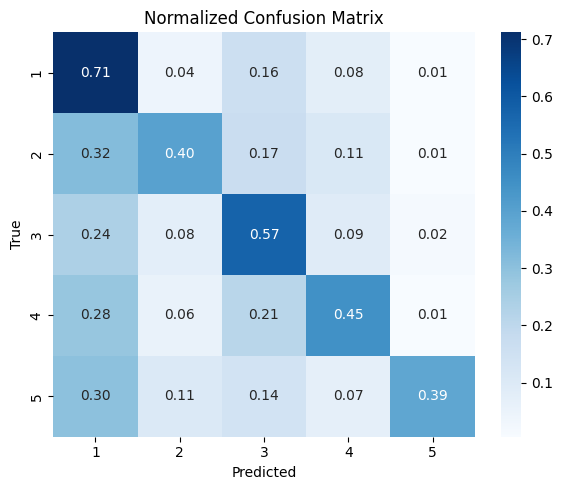

In [57]:
metrics = evaluate_model_logits(test_data, model, tokenizer)